In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np

from sklearn.metrics import mean_absolute_error        # 평균 절대값 에러(모델 평가 지수)
from sklearn.metrics import mean_squared_error         # 평균 제곱근 에러(모델 평가 지수)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
filename = '/content/drive/MyDrive/Colab Notebooks/10주차/data/stock.csv'
data = np.loadtxt(filename, delimiter=',', dtype=np.float32)
# 정규화
data = (data - np.min(data, 0)) / (np.max(data, 0) - np.min(data, 0))

print(data.shape)
print(len(data) * 0.8)    # 데이터 나누기 위해서

(9288, 5)
7430.400000000001


In [4]:
x_data = []                         # 입력데이터 리스트
y_data = []                         # 출력데이터 리스트

for i in range(0, len(data) - 5) :   # 9288 - 5
    x = data[i  :  i + 5,  :  ]        # 0 – 4 / 1 - 5 / 2 - 6 /...........
    y = data[i + 5, [-1]]            # 5      / 6      / 7     / .........
    x_data.append(x)
    y_data.append(y)

x_data = np.array(x_data)       # 리스트를 배열로 ..
y_data = np.array(y_data)


In [5]:
print(x_data[0])                #  첫번쩨 입력 데이타
print(y_data[0])                # 첫번째 리벨

[[0.00024397 0.00024389 0.00024715 0.00034218 0.00022765]
 [0.00022654 0.00022647 0.0002295  0.00033218 0.00021014]
 [0.00022654 0.00024389 0.0002295  0.00236327 0.00022765]
 [0.00022654 0.00022647 0.00021185 0.00258739 0.00019263]
 [0.00017426 0.0001742  0.00012358 0.00099453 0.00012258]]
[0.0001401]


In [6]:
x_train = x_data[ : 7430]
y_train = y_data[ : 7430]
print(x_train.shape)
print(y_train.shape)
x_test = x_data[7430 : ]
y_test = y_data[7430 : ]
print(x_test.shape)
print(y_test.shape)

(7430, 5, 5)
(7430, 1)
(1853, 5, 5)
(1853, 1)


## LSTM_1 모델

In [7]:
model = Sequential()
model.add(LSTM(32, input_shape=(5, 5)))
model.add(Dense(1, activation='linear'))
model.summary()

print(f"Total params : {(32 * 32 * 4) + (5 * 32 * 4) + ( 32 * 4 ) + (32 * 1 ) + 1 }")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4897 (19.13 KB)
Trainable params: 4897 (19.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Total params : 4897


In [8]:
model_checkpoint = ModelCheckpoint(filepath =  "./model.h5", monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)

# 모델 학습과정 설정하기
model.compile(loss = 'mse', optimizer = optimizers.Adam(0.001), metrics=['accuracy'])

In [9]:
hist = model.fit(
                  x_train, y_train,                        # 입력 / 라벨
                  epochs = 3, batch_size = 10,            # 학습 회수 / 학습 10번 후 오차 감소
                  validation_data=(x_test, y_test),        # 검증 데이터
                  callbacks = [model_checkpoint, early_stopping] # 저장 및 모니터링
                 )

Epoch 1/3
743/743 [==============================] - ETA: 0s - loss: 2.5140e-04 - accuracy: 0.0016
Epoch 1: val_loss improved from inf to 0.00143, saving model to ./model.h5
743/743 [==============================] - 7s 6ms/step - loss: 2.5140e-04 - accuracy: 0.0016 - val_loss: 0.0014 - val_accuracy: 5.3967e-04
Epoch 2/3
 21/743 [..............................] - ETA: 3s - loss: 2.5479e-05 - accuracy: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


734/743 [============================>.] - ETA: 0s - loss: 2.1708e-05 - accuracy: 0.0016
Epoch 2: val_loss did not improve from 0.00143
743/743 [==============================] - 3s 4ms/step - loss: 2.1696e-05 - accuracy: 0.0016 - val_loss: 0.0017 - val_accuracy: 5.3967e-04
Epoch 3/3
737/743 [============================>.] - ETA: 0s - loss: 2.3303e-05 - accuracy: 0.0016
Epoch 3: val_loss did not improve from 0.00143
743/743 [==============================] - 3s 4ms/step - loss: 2.3206e-05 - accuracy: 0.0016 - val_loss: 0.0020 - val_accuracy: 5.3967e-04


In [10]:
model.evaluate(x_test, y_test) # 모델 평가

# 테스트 데이터 입력하여 예측값 구하기
predict = model.predict(x_test)

# 테스트 세트에 대한 평균 절댓값 오차
mae = mean_absolute_error(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = mse**0.5
print(mae)
print(mse)
print(rmse)

58/58 [==============================] - 2s 5ms/step
0.033447552
0.0020420437
0.04518897787407172


## LSTM_2 모델

In [11]:
model = Sequential()
model.add(LSTM(64, input_shape=(5, 5)))
model.add(Dense(128, activation='relu'))        # Dense 층 추가
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 26369 (103.00 KB)
Trainable params: 26369 (103.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model_checkpoint = ModelCheckpoint(filepath =  "./model.h5", monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)

# 모델 학습과정 설정하기
model.compile(loss = 'mse', optimizer = optimizers.Adam(0.001), metrics=['accuracy'])

In [13]:
hist = model.fit(
                  x_train, y_train,                        # 입력 / 라벨
                  epochs = 3, batch_size = 10,            # 학습 회수 / 학습 10번 후 오차 감소
                  validation_data=(x_test, y_test),        # 검증 데이터
                  callbacks = [model_checkpoint, early_stopping] # 저장 및 모니터링
                 )

Epoch 1/3
742/743 [============================>.] - ETA: 0s - loss: 8.1062e-05 - accuracy: 0.0016
Epoch 1: val_loss improved from inf to 0.00026, saving model to ./model.h5
743/743 [==============================] - 6s 5ms/step - loss: 8.0997e-05 - accuracy: 0.0016 - val_loss: 2.5567e-04 - val_accuracy: 5.3967e-04
Epoch 2/3
 42/743 [>.............................] - ETA: 2s - loss: 2.0725e-05 - accuracy: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


736/743 [============================>.] - ETA: 0s - loss: 2.7106e-05 - accuracy: 0.0015
Epoch 2: val_loss improved from 0.00026 to 0.00023, saving model to ./model.h5
743/743 [==============================] - 4s 5ms/step - loss: 2.7109e-05 - accuracy: 0.0016 - val_loss: 2.2676e-04 - val_accuracy: 5.3967e-04
Epoch 3/3
743/743 [==============================] - ETA: 0s - loss: 2.8515e-05 - accuracy: 0.0016
Epoch 3: val_loss did not improve from 0.00023
743/743 [==============================] - 6s 7ms/step - loss: 2.8515e-05 - accuracy: 0.0016 - val_loss: 7.0958e-04 - val_accuracy: 5.3967e-04


In [14]:
model.evaluate(x_test, y_test) # 모델 평가

# 테스트 데이터 입력하여 예측값 구하기
predict = model.predict(x_test)

# 테스트 세트에 대한 평균 절댓값 오차
mae = mean_absolute_error(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = mse**0.5
print(mae)
print(mse)
print(rmse)

58/58 [==============================] - 1s 2ms/step
0.020960502
0.00070957927
0.026637929123802872


## LSTM_3 모델

In [15]:
model = Sequential()
model.add(LSTM(64, input_shape=(5, 5), return_sequences=True))
model.add(LSTM(64))                        # RNN 2층 추가
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 64)             17920     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 59393 (232.00 KB)
Trainable params: 59393 (232.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model_checkpoint = ModelCheckpoint(filepath =  "./model.h5", monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)

# 모델 학습과정 설정하기
model.compile(loss = 'mse', optimizer = optimizers.Adam(0.001), metrics=['accuracy'])

In [17]:
hist = model.fit(
                  x_train, y_train,                        # 입력 / 라벨
                  epochs = 3, batch_size = 10,            # 학습 회수 / 학습 10번 후 오차 감소
                  validation_data=(x_test, y_test),        # 검증 데이터
                  callbacks = [model_checkpoint, early_stopping] # 저장 및 모니터링
                 )

Epoch 1/3
742/743 [============================>.] - ETA: 0s - loss: 2.0125e-04 - accuracy: 0.0016
Epoch 1: val_loss improved from inf to 0.00096, saving model to ./model.h5
743/743 [==============================] - 9s 9ms/step - loss: 2.0099e-04 - accuracy: 0.0016 - val_loss: 9.5870e-04 - val_accuracy: 5.3967e-04
Epoch 2/3
 31/743 [>.............................] - ETA: 3s - loss: 3.1587e-05 - accuracy: 0.0032

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


734/743 [============================>.] - ETA: 0s - loss: 5.3352e-05 - accuracy: 0.0015
Epoch 2: val_loss did not improve from 0.00096
743/743 [==============================] - 5s 6ms/step - loss: 5.3151e-05 - accuracy: 0.0016 - val_loss: 0.0026 - val_accuracy: 5.3967e-04
Epoch 3/3
737/743 [============================>.] - ETA: 0s - loss: 4.0340e-05 - accuracy: 0.0016
Epoch 3: val_loss did not improve from 0.00096
743/743 [==============================] - 5s 7ms/step - loss: 4.0569e-05 - accuracy: 0.0016 - val_loss: 0.0013 - val_accuracy: 5.3967e-04


In [18]:
model.evaluate(x_test, y_test) # 모델 평가

# 테스트 데이터 입력하여 예측값 구하기
predict = model.predict(x_test)

# 테스트 세트에 대한 평균 절댓값 오차
mae = mean_absolute_error(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = mse**0.5
print(mae)
print(mse)
print(rmse)

58/58 [==============================] - 1s 4ms/step
0.02643754
0.0013478262
0.03671275271228316


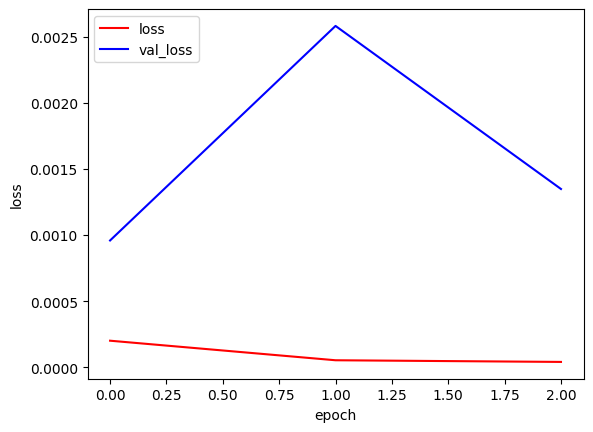

In [19]:
# 그래프 출력
import matplotlib.pyplot as plt
# 과정 살펴보기
plt.plot(hist.history['loss'], 'r', label = 'loss')
plt.plot(hist.history['val_loss'], 'b', label = 'val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

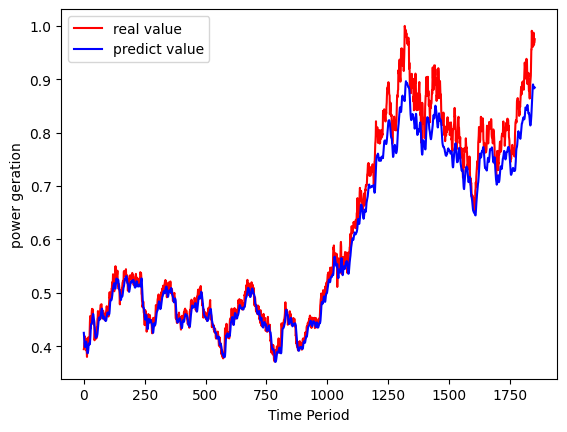

In [20]:
plt.plot(y_test[ : ], 'r', label = "real value")
plt.plot(predict[ : ], 'b', label = "predict value")
plt.xlabel("Time Period")
plt.ylabel('power geration')
plt.legend(loc='upper left')
plt.show()